# Demo 2: Integrate and Analyze
This demo run a user-specified analysis that takes GDDP data descriptors and user-provided data as arguments. DataSpaces downloads any necessary data and runs the user-provided function. Finally, the result is returned to the user.

In [1]:
from dx_interface import DXInterface
from wet_bulb import *
import netCDF4 as nc
from scipy.interpolate import RegularGridInterpolator
import numpy as np
import matplotlib.pyplot as plt

Initialize the data interface to a well-known socket.

In [2]:
client = DXInterface('20.84.58.28:8000')

Compute time-independent air pressure values as a function of elevation.

In [3]:
f=nc.Dataset('elev_721x1440.nc'); #geopotential
z=f['z'][:,:,:]/9.81;z_orig=z[0,:,:]; #converted to meters, centered on 180W
lat_cur=np.linspace(-90,90,721); #because elev data file is 721x1440
lon_cur=np.linspace(-180,180,1440);
lat_des=np.linspace(-90,90,600)
lon_des=np.linspace(-180,180,1440);
interp = RegularGridInterpolator((lat_cur, lon_cur), z_orig,bounds_error=False,fill_value=None);
X,Y = np.meshgrid(lat_des,lon_des,indexing='ij')
z_interp=interp((X,Y))
psfc_chunk=pressurefromelev(z_interp[:,:]);


Write the user-computed pressure data to DataSpaces, with a projection and resolution matching GDDP data. These data will be available for download or any future computations.

In [4]:
data_tas, lat, lon = client.query(source = 'planetary-gddp',
		variable = 'tas',
		model = 'ACCESS-CM2',
		start_date = '1982-10-28',
		end_date = '1982-10-29',
		scenario='historical',
		quality=0,
		lb=(0,0),
		ub=(500,500),
		geo_lb = (38.9, -77.0),
		geo_ub = (40.7,-74.0))
data_huss, lat, lon = client.query(source = 'planetary-gddp',
		variable = 'huss',
		model = 'ACCESS-CM2',
		start_date = '1982-10-28',
		end_date = '1982-10-29',
		scenario='historical',
		quality=0,
		lb=(0,0),
		ub=(500,500),
		geo_lb = (38.9, -77.0),
		geo_ub = (40.7,-74.0))

data_pressure = psfc_chunk[0:500,0:500]

v:tas,m:ACCESS-CM2,s:historical,t:723731_723732,l:0_0,u:500_500
v:huss,m:ACCESS-CM2,s:historical,t:723731_723732,l:0_0,u:500_500


In [5]:
data_pressure.shape

(500, 500)

Define a function to be run on data in the DataSpaces staging server. `HeatIndex` takes three N-D arrays as arguments, and runs a vectorized kernel element-wise on these arrays. This highlights the pattern of running an element-wise kernel, but any operation performed upon a tuple of N-D arrays is supported. There is no required return value format.

In [6]:
def HeatIndex(t, p, h):
        def foo(tf, v):
            return tf * v
        def HeatIndexKernel(t1, p1, h1):
            return(foo(t1*p1, h1))
        import numpy
        HeatIndexV = numpy.vectorize(HeatIndexKernel)
        return(HeatIndexV(t, p, h))

Specify an argument list to be used for instantiating `HeatIndex`. The first and last argument specify data to be downloaded from Planetary Comptuer (or loaded from the DataSpaces cache, if available). The middle argument is the previously uploaded pressure data. 

In [7]:
result = HeatIndex(data_tas,data_pressure,data_huss)

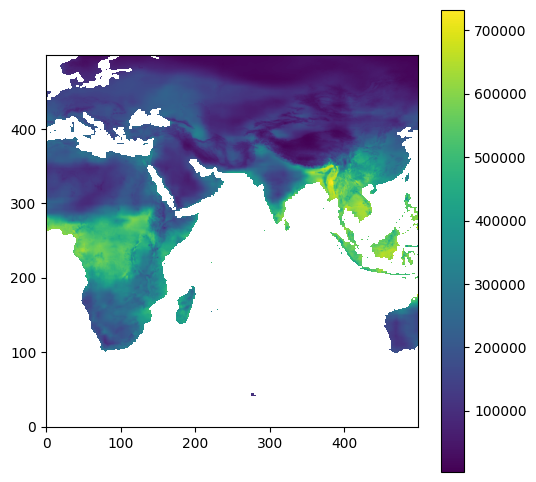

In [8]:
plt.figure(figsize=(6,6))
plt.imshow(result,origin='lower')
plt.colorbar()

In [9]:
wb_result=WetBulbArrays(data_tas,data_pressure,data_huss)

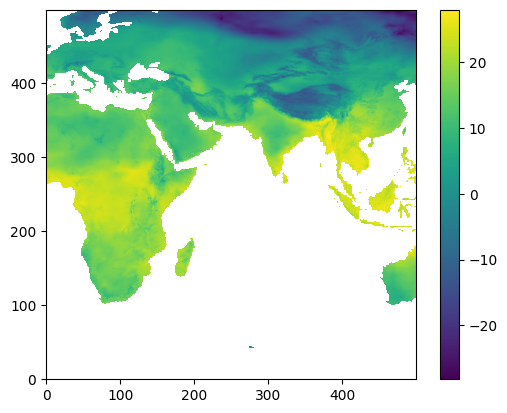

In [10]:
plt.imshow(wb_result,origin='lower')
plt.colorbar()